# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Метод k-средних, предобработка признаков


###### <hr\>
**Общая информация**

**Срок сдачи:** 28 ноября 2018, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 28 ноября, -4 балла после 06:00 5 декабря, -6 баллов после 06:00 12 декабря, -8 баллов после 19 декабря

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush

Необходимо в slack создать таск в приватный чат:
/todo Фамилия Имя ссылка на гитхаб @alkhamush
Пример:
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush
Дополнительно нужно просто скинуть ссылку в slack в личный чат

Используйте данный Ipython Notebook при оформлении домашнего задания.

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means. Задание считается выполненным, если Ваша реализация работает быстрее реализации из sklearn.

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл
<hr\>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

%load_ext pycodestyle_magic

In [3]:
#%%pycodestyle


class MyKmeans: 
    
    def __init__(self, k=2, metric='euclidean', max_iter=1000, random_state=None, init='random'):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """
        
        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        if init == 'random':
            self.init = self.init_random
        elif init == 'k-means':
            self.init = self.init_kmeans
            
    def init_random(self, X):
        mean = np.mean(X, axis = 0)
        std = np.std(X, axis = 0)
        centers = np.random.randn(self.k, X.shape[1])*std + mean
        return centers
    
    def init_kmeans(self, X):
        centers = np.empty((self.k, X.shape[1]))
        centers[0] = X[np.random.choice(X.shape[0])]
        for i in range(1, self.k):
            distances = self.numpy_euc_dist(X, centers[:i, :])
            dist = distances.min(axis=1)
            weight = dist / dist.sum()
            centers[i] = X[np.random.choice(X.shape[0], p=weight)]
        return centers
        
    def numpy_euc_dist(self, X, Y):
        x_dist = (X ** 2).sum(axis=1)
        y_dist = (Y ** 2).sum(axis=1)
        xy_dist = X.dot(Y.T)
        dist = - 2 * xy_dist + y_dist + x_dist.reshape(-1, 1)
        return np.sqrt(dist)

    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """
        
        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)
        
        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])
        
        # Массив с центройдами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))
        
        ## Your Code Here
        # ...
        centers = self.init(X)
        new_centers = deepcopy(centers)
        X = X.astype(float)
        
        for _ in range(self.max_iter):
            distances = self.numpy_euc_dist(X, centers)
            self.labels = np.argmin(distances, axis=1)
            for i in range(self.k):
                if len(self.labels[self.labels == i]) != 0:
                    new_centers[i] = np.mean(X[self.labels == i], axis=0)
            if np.linalg.norm(new_centers - centers) == 0:
                break
            centers = deepcopy(new_centers)
        self.centroids = centers
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера
        
        Возвращает метку ближайшего кластера для каждого объекта
        """

class MiniBatchKMeans(MyKmeans):
    def __init__(self, k=2, metric='euclidean', max_iter=1000, random_state=None,
                 init='random', butch_size=10):
        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        if init == 'random':
            self.init = self.init_random
        elif init == 'k-means':
            self.init = self.init_kmeans
        self.butch_size = butch_size
        
    def fit(self, X, y=None):
        np.random.seed(self.random_state)
        self.labels = np.empty(X.shape[0])
        self.centroids = np.empty((self.k, X.shape[1]))
        centers = self.init(X)
        new_centers = deepcopy(centers)
        X = X.astype(float)
        
        for _ in range(self.max_iter):
            mask = np.random.choice(np.arange(X.shape[0]), self.butch_size)
            M = X[mask]
            distances = self.numpy_euc_dist(M, centers)
#             for i, x in enumerate(mask):
            self.labels[mask] = np.argmin(distances, axis=1)
#             self.labels = self.numpy_euc_dist(M, centers).argmin(axis=1)
            for i in range(self.k):
                if len(self.labels[self.labels == i]) != 0:
                    new_centers[i] = np.mean(X[self.labels == i], axis=0)
            if np.linalg.norm(new_centers - centers) <= 0.05:
                break
            centers = deepcopy(new_centers)
        self.labels = self.numpy_euc_dist(X, centers).argmin(axis=1)
        self.centroids = centers
        return self

### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [4]:
from sklearn.datasets import make_blobs

In [134]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

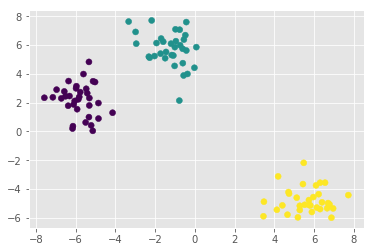

In [6]:
plt.scatter(X[:,0], X[:, 1], c=y)

Проверьте Вашу имплементацию на простых данных (без этого пункта ДЗ не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

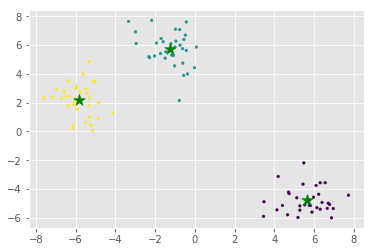

In [109]:
## Работоспособность MyKmeans
clf = MyKmeans(k=3)
clf.fit(X)

plt.scatter(X[:,0], X[:,1], s=7, c=clf.labels)
plt.scatter(clf.centroids[:,0], clf.centroids[:,1], marker='*', c='g', s=150)

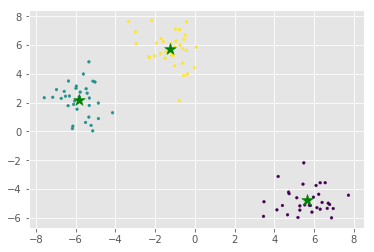

In [110]:
## Работоспособность MyKmeans++
clf = MyKmeans(k=3, init='k-means')
clf.fit(X)

plt.scatter(X[:,0], X[:,1], s=7, c=clf.labels)
plt.scatter(clf.centroids[:,0], clf.centroids[:,1], marker='*', c='g', s=150)

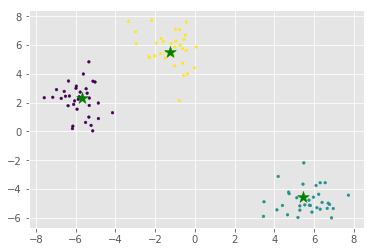

In [136]:
## Работоспособность MyKmeans с MiniBatchMyKmeans
clf = MiniBatchKMeans(k=3)
clf.fit(X)

plt.scatter(X[:,0], X[:,1], s=7, c=clf.labels)
plt.scatter(clf.centroids[:,0], clf.centroids[:,1], marker='*', c='g', s=150)

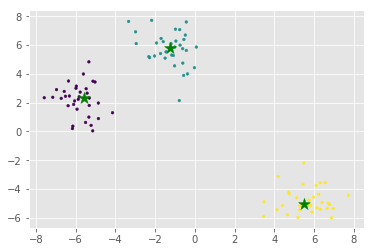

In [127]:
## Работоспособность MyKmeans++ с MiniBatchMyKmeans
clf = MiniBatchKMeans(k=3, init='k-means')
clf.fit(X)

plt.scatter(X[:,0], X[:,1], s=7, c=clf.labels)
plt.scatter(clf.centroids[:,0], clf.centroids[:,1], marker='*', c='g', s=150)

0.09674572944641113


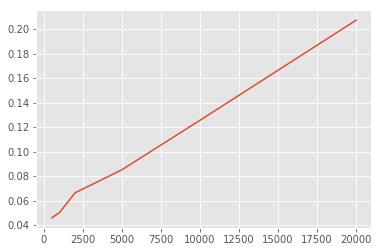

In [38]:
## Время выполнения алгоритма Kmeans из sklearn
import time
from sklearn.cluster import KMeans
samples = [500, 1000, 2000, 5000, 10000, 20000]
t1 = []
for s in samples:
    X, y = make_blobs(n_samples=s, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    clf = KMeans(n_clusters=3)
    tau = time.time()
    clf.fit(X)
    t1.append(time.time() - tau)
print(np.mean(t1))
plt.plot(samples, t1)

0.0230408509572347


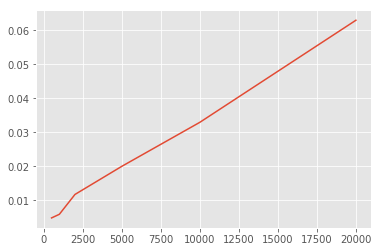

In [69]:
## Время выполнения алгоритма MyKmeans
samples = [500, 1000, 2000, 5000, 10000, 20000]
t2 = []
for s in samples:
    X, y = make_blobs(n_samples=s, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    clf = MyKmeans(k=3, max_iter=300)
    tau = time.time()
    clf.fit(X)
    t2.append(time.time() - tau)
print(np.mean(t2))
plt.plot(samples, t2)

0.025459647178649902


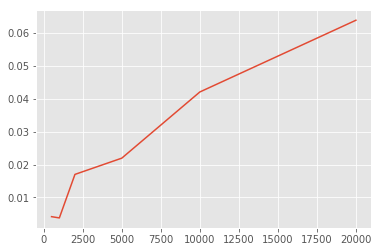

In [71]:
## Время выполнения алгоритма MyKmeans++
samples = [500, 1000, 2000, 5000, 10000, 20000]
t3 = []
for s in samples:
    X, y = make_blobs(n_samples=s, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    clf = MyKmeans(k=3, max_iter=300, init='k-means')
    tau = time.time()
    clf.fit(X)
    t3.append(time.time() - tau)
print(np.mean(t3))
plt.plot(samples, t3)

0.022769689559936523


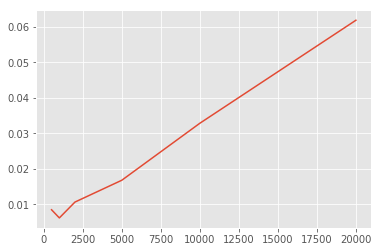

In [166]:
## Время выполнения алгоритма MyKmeans с MiniBatchMyKmeans
samples = [500, 1000, 2000, 5000, 10000, 20000]
t4 = []
for s in samples:
    X, y = make_blobs(n_samples=s, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    clf = MiniBatchKMeans(k=3, max_iter=300, butch_size=100)
    tau = time.time()
    clf.fit(X)
    t4.append(time.time() - tau)
print(np.mean(t4))
plt.plot(samples, t4)

0.025892019271850586


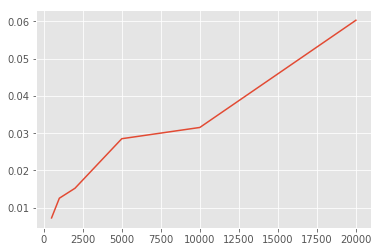

In [168]:
## Время выполнения алгоритма  MyKmeans++ с MiniBatchMyKmeans
samples = [500, 1000, 2000, 5000, 10000, 20000]
t5 = []
for s in samples:
    X, y = make_blobs(n_samples=s, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    clf = MiniBatchKMeans(k=3, max_iter=300, butch_size=100, init='k-means')
    tau = time.time()
    clf.fit(X)
    t5.append(time.time() - tau)
print(np.mean(t5))
plt.plot(samples, t5)

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [8]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns.head()

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


In [15]:
df_sns = df_sns.drop(['gradyear', 'gender', 'age', 'friends'], axis=1)
X = df_sns.values
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [12]:
words = df_sns.columns

In [40]:
%%time
## MyKMeans
clf = MyKmeans(k=10)
clf.fit(X)

for i, centr in enumerate(clf.centroids):
    print(words[np.argsort(centr)[-5:]], clf.labels[clf.labels == i].size)

Index(['sex', 'drunk', 'cute', 'hot', 'sexy'], dtype='object') 2055
Index(['drunk', 'sex', 'hair', 'drugs', 'kissed'], dtype='object') 883
Index(['death', 'bible', 'jesus', 'tennis', 'blonde'], dtype='object') 18064
Index(['death', 'church', 'god', 'jesus', 'bible'], dtype='object') 455
Index(['clothes', 'cute', 'dance', 'dress', 'shopping'], dtype='object') 3668
Index(['hair', 'clothes', 'shopping', 'abercrombie', 'hollister'], dtype='object') 819
Index(['basketball', 'football', 'shopping', 'sports', 'soccer'], dtype='object') 676
Index(['football', 'rock', 'music', 'band', 'marching'], dtype='object') 569
Index(['hot', 'clothes', 'cute', 'shopping', 'mall'], dtype='object') 1085
Index(['football', 'volleyball', 'basketball', 'baseball', 'softball'], dtype='object') 1726
CPU times: user 6.23 s, sys: 174 ms, total: 6.41 s
Wall time: 1.74 s


In [41]:
%%time
## MyKMeans++
clf = MyKmeans(k=10, init='k-means')
clf.fit(X)

for i, centr in enumerate(clf.centroids):
    print(words[np.argsort(centr)[-5:]], clf.labels[clf.labels == i].size)

/home/Albert/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in sqrt
/home/Albert/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less


Index(['sports', 'rock', 'basketball', 'football', 'baseball'], dtype='object') 484
Index(['god', 'rock', 'music', 'band', 'marching'], dtype='object') 746
Index(['clothes', 'mall', 'shopping', 'abercrombie', 'hollister'], dtype='object') 813
Index(['sex', 'death', 'drunk', 'bible', 'blonde'], dtype='object') 18604
Index(['hot', 'mall', 'football', 'shopping', 'cheerleading'], dtype='object') 619
Index(['shopping', 'music', 'cute', 'dress', 'dance'], dtype='object') 897
Index(['shopping', 'sports', 'basketball', 'volleyball', 'softball'], dtype='object') 894
Index(['drunk', 'sex', 'hair', 'drugs', 'kissed'], dtype='object') 872
Index(['clothes', 'mall', 'church', 'cute', 'shopping'], dtype='object') 3895
Index(['sports', 'tennis', 'basketball', 'football', 'soccer'], dtype='object') 2176
CPU times: user 8.75 s, sys: 223 ms, total: 8.98 s
Wall time: 2.42 s


In [48]:
%%time
## MyKMeans с MiniBatchMyKMeans
clf = MiniBatchKMeans(k=10, butch_size=200)
clf.fit(X)

for i, centr in enumerate(clf.centroids):
    print(words[np.argsort(centr)[-5:]], clf.labels[clf.labels == i].size)

Index(['music', 'soccer', 'band', 'blonde', 'tennis'], dtype='object') 495
Index(['shopping', 'cute', 'music', 'dress', 'dance'], dtype='object') 707
Index(['sports', 'church', 'basketball', 'baseball', 'football'], dtype='object') 2631
Index(['sex', 'jesus', 'bible', 'death', 'blonde'], dtype='object') 17161
Index(['clothes', 'mall', 'shopping', 'abercrombie', 'hollister'], dtype='object') 859
Index(['hot', 'sexy', 'mall', 'cute', 'shopping'], dtype='object') 4202
Index(['basketball', 'sports', 'softball', 'soccer', 'volleyball'], dtype='object') 1413
Index(['sex', 'music', 'hair', 'kissed', 'rock'], dtype='object') 358
Index(['sex', 'drunk', 'hair', 'kissed', 'drugs'], dtype='object') 1122
Index(['jesus', 'god', 'bible', 'band', 'marching'], dtype='object') 1052
CPU times: user 1.12 s, sys: 27.6 ms, total: 1.14 s
Wall time: 347 ms


In [49]:
%%time
## MyKMeans++ с MiniBatchMyKMeans
clf = MiniBatchKMeans(k=10, butch_size=200, init='k-means')
clf.fit(X)

for i, centr in enumerate(clf.centroids):
    print(words[np.argsort(centr)[-5:]], clf.labels[clf.labels == i].size)

/home/Albert/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in sqrt
/home/Albert/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less


Index(['swimming', 'soccer', 'band', 'blonde', 'tennis'], dtype='object') 941
Index(['shopping', 'cute', 'music', 'dress', 'dance'], dtype='object') 713
Index(['sports', 'church', 'basketball', 'baseball', 'football'], dtype='object') 2596
Index(['sex', 'jesus', 'bible', 'death', 'blonde'], dtype='object') 16801
Index(['clothes', 'mall', 'shopping', 'abercrombie', 'hollister'], dtype='object') 861
Index(['hot', 'sexy', 'mall', 'cute', 'shopping'], dtype='object') 4174
Index(['basketball', 'sports', 'softball', 'soccer', 'volleyball'], dtype='object') 1393
Index(['sex', 'music', 'hair', 'kissed', 'rock'], dtype='object') 356
Index(['sex', 'drunk', 'hair', 'kissed', 'drugs'], dtype='object') 1117
Index(['jesus', 'god', 'bible', 'band', 'marching'], dtype='object') 1048
CPU times: user 1.57 s, sys: 48.5 ms, total: 1.62 s
Wall time: 516 ms


## Вывод

Кластеры похожи, разделяются на примерно одинаковые тематики. Kmeans побыстрее Kmeans++, т.к. теряется время на инициадизацию центроидов. MiniBatch явно быстрее Kmeans, что логично на больших данных. На вскидку по качеству сложно выделить какой-то метод, но MiniBatch по времени явно лучше.